In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import datetime

In [115]:
dimension_path = "../DS_2_DataStaging/DimensionsPre/"
fact_table_path = "../DS_2_DataStaging/FactTable/"
data_path = "../DS_2_DataStaging/Data/"

In [116]:
Date_dimension = pd.read_csv(dimension_path+"Date_dimension/Date_dimension.csv")
Mobility_dimension = pd.read_csv(dimension_path+"Mobility_dimension/Mobility_dimension.csv")
Patient_dimension = pd.read_csv(dimension_path+"Patient_dimension/Patient_dimension.csv")
PHU_Location_dimension = pd.read_csv(dimension_path+"PHU_Location_dimension/PHU_Location_dimension.csv")
Special_Measures_dimension = pd.read_csv(dimension_path+"Special_Measures_dimension/Special_Measures_dimension.csv")
Weather_dimension = pd.read_csv(dimension_path+"Weather_dimension/Weather_dimension.csv")
fact_table = pd.read_csv(fact_table_path+"Covid19_Tracking_Fact_Table.csv")[:1000]


In [117]:
def process_date(d, incubation_days=-2):
    dt = datetime.datetime.strptime(d, '%Y-%m-%d')
    add_incubation = dt + datetime.timedelta(days=incubation_days)
    day_string = add_incubation.strftime("%Y-%m-%d")
    return(day_string)
def find_value_from_key(key,attribute,dimension):
    row = dimension[dimension['surrogate_key']==key]
    return row[attribute].values[0]

In [118]:
data = pd.DataFrame()

In [119]:
data['Onset_date'] = fact_table['Onset_date_key'].map(lambda x: find_value_from_key(x,'date', Date_dimension))

In [120]:
data['Onset_date'] = data['Onset_date'].map(process_date)

In [121]:
data['Age_Group'] = fact_table['Patient_key'].map(lambda x: find_value_from_key(x,'Age_Group', Patient_dimension))
data = data[data['Age_Group'] != 'UNKNOWN']

In [122]:
data['Client_Gender'] = fact_table['Patient_key'].map(lambda x: find_value_from_key(x,'Client_Gender', Patient_dimension))

In [123]:
data['mobility'] = fact_table['Mobility_key'].map(lambda x: find_value_from_key(x,'parks_percent_change_from_baseline', Mobility_dimension))

In [124]:
data['Special_Measures'] = fact_table['Special_measure_key'].map(lambda x: find_value_from_key(x,'Title', Special_Measures_dimension)) 

In [125]:
data['resolved'] = fact_table['Resolved'].map(lambda x: x)
# data['resolved'] = fact_table['Resolved'].map(lambda x: 1 if x>=1 else 0)

In [126]:
data.head()

,Onset_date,Age_Group,Client_Gender,mobility,Special_Measures,resolved
0,2020-11-17,70s,FEMALE,-15.0,Control,1
1,2020-11-20,<20,MALE,-15.0,Control,1
2,2020-11-19,30s,MALE,-15.0,Control,1
3,2020-11-21,30s,MALE,-15.0,Control,1
4,2020-11-22,<20,FEMALE,-15.0,Control,1


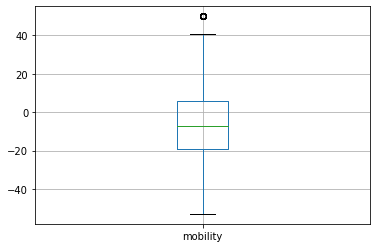

In [127]:
data.boxplot(column=['mobility'])

(array([0.23 , 0.   , 0.   , 0.   , 0.   , 0.785, 0.   , 0.   , 0.   ,
        0.   , 0.765, 0.   , 0.   , 0.   , 0.   , 0.8  , 0.   , 0.   ,
        0.   , 0.   , 0.22 , 0.   , 0.   , 0.   , 0.   , 0.5  , 0.   ,
        0.   , 0.   , 0.   , 0.79 , 0.   , 0.   , 0.   , 0.   , 0.75 ,
        0.   , 0.   , 0.   , 0.16 ]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
        7.8, 8. ]),
 <a list of 1 Patch objects>)

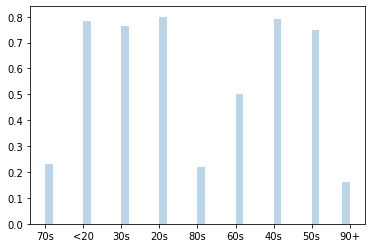

In [128]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40)
plt.hist(data['Age_Group'], **kwargs)

# A.2

In [129]:
data.isna().sum()

Onset_date          0
Age_Group           0
Client_Gender       0
mobility            0
Special_Measures    0
resolved            0
dtype: int64

In [130]:
data['Age_Group'].drop_duplicates()

0     70s
1     <20
2     30s
6     20s
7     80s
13    60s
15    40s
44    50s
50    90+
Name: Age_Group, dtype: object

In [131]:
mapping_age = {
    '<20':0,
    '20s':1,
    '30s':2,
    '40s':3,
    '50s':4,
    '60s':5,
    '70s':6,
    '80s':7,
    '90+':8
}
data['Age_Group'] = data['Age_Group'].map(lambda x : mapping_age[x])
    

In [132]:
data['Client_Gender'].drop_duplicates()

0    FEMALE
1      MALE
Name: Client_Gender, dtype: object

In [133]:
mapping_gender = {
    'MALE':0,
    'FEMALE':1
}
data['Client_Gender'] = data['Client_Gender'].map(lambda x : mapping_gender[x])


In [134]:
data['Special_Measures'].drop_duplicates()

0       Control
57     Lockdown
187     Protect
194    Restrict
Name: Special_Measures, dtype: object

In [135]:
# mapping_special = {
#     'Control':0,
#     'Lockdown':1,
#     'Protect':2,
#     'Restrict':3
# #     'Control':0,
# #     'Control':0,

# }
# data['Special_Measures'] = data['Special_Measures'].map(lambda x : mapping_special[x])


In [136]:
one_hot = pd.get_dummies(data.Special_Measures, prefix='Special_Measures')
one_hot.shape

(1000, 4)

In [137]:
data.shape

(1000, 6)

In [138]:
data = pd.concat([data,one_hot],axis=1)
data = data.drop(columns=['Special_Measures'])

### normalisation

In [139]:
#normalize mobility
data['mobility'] = (data['mobility']-data['mobility'].min())/(data['mobility'].max()-data['mobility'].min())
data['Age_Group'] = (data['Age_Group']-data['Age_Group'].min())/(data['Age_Group'].max()-data['Age_Group'].min())

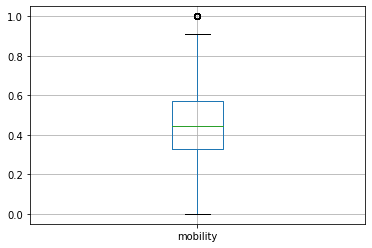

In [140]:
data.boxplot(column=['mobility'])

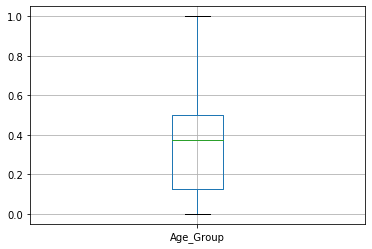

In [141]:
data.boxplot(column=['Age_Group'])

In [142]:
data

,Onset_date,Age_Group,Client_Gender,mobility,resolved,Special_Measures_Control,Special_Measures_Lockdown,Special_Measures_Protect,Special_Measures_Restrict
0,2020-11-17,0.750,1,0.368932,1,1,0,0,0
1,2020-11-20,0.000,0,0.368932,1,1,0,0,0
2,2020-11-19,0.250,0,0.368932,1,1,0,0,0
3,2020-11-21,0.250,0,0.368932,1,1,0,0,0
4,2020-11-22,0.000,1,0.368932,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
995,2020-11-16,0.000,0,0.912621,1,1,0,0,0
996,2020-11-22,0.250,0,0.912621,1,1,0,0,0
997,2020-10-16,1.000,1,0.912621,1,1,0,0,0
998,2020-11-22,0.125,1,0.912621,1,1,0,0,0


### undersampling

In [143]:
shuffle_unresolved = shuffle(data[data['resolved']==0])
shuffle_resolved = shuffle(data[data['resolved']==1])
shuffle_resolved = shuffle_resolved[:len(shuffle_unresolved)]
undersampled_data = shuffle_resolved.append(shuffle_unresolved)
undersampled_data = shuffle(undersampled_data)

In [144]:
len(undersampled_data)

62

# Part B

In [145]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

In [146]:
['Onset_date', 'Age_Group', 'Client_Gender', 'mobility', 'resolved', 'Special_Measures_Control', 'Special_Measures_Lockdown', 'Special_Measures_Protect', 'Special_Measures_Restrict']

['Onset_date',
 'Age_Group',
 'Client_Gender',
 'mobility',
 'resolved',
 'Special_Measures_Control',
 'Special_Measures_Lockdown',
 'Special_Measures_Protect',
 'Special_Measures_Restrict']

In [147]:
iris = load_iris()
X = undersampled_data[['Age_Group', 'Client_Gender', 'mobility', 'Special_Measures_Control', 'Special_Measures_Lockdown', 'Special_Measures_Protect', 'Special_Measures_Restrict']]
y = undersampled_data['resolved']
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree = decision_tree.fit(X, y)
r = export_text(decision_tree, feature_names=['Age_Group', 'Client_Gender', 'mobility', 'Special_Measures_Control', 'Special_Measures_Lockdown', 'Special_Measures_Protect', 'Special_Measures_Restrict'])

In [148]:
print(r)

|--- Age_Group <= 0.81
|   |--- Age_Group <= 0.31
|   |   |--- class: 1
|   |--- Age_Group >  0.31
|   |   |--- class: 1
|--- Age_Group >  0.81
|   |--- Client_Gender <= 0.50
|   |   |--- class: 0
|   |--- Client_Gender >  0.50
|   |   |--- class: 0



In [149]:
undersampled_data.head()

,Onset_date,Age_Group,Client_Gender,mobility,resolved,Special_Measures_Control,Special_Measures_Lockdown,Special_Measures_Protect,Special_Measures_Restrict
909,2020-11-23,1.000,1,0.912621,0,1,0,0,0
480,2021-02-15,0.500,1,0.077670,0,1,0,0,0
439,2021-02-18,0.500,1,0.000000,0,1,0,0,0
965,2020-11-23,0.875,0,0.912621,0,1,0,0,0
640,2020-11-30,0.875,0,0.572816,0,1,0,0,0
